## Unir y preparar los ficheros bajados de IVIMA.

Los datos del IVIMA hay que bajarlos manualmente desde: http://www.planalquila.org/

In [1]:
## Imports y directorios in/out

import pandas as pd
import os
import numpy as np

input_dir = '../../../data/raw/IVIMA/'
out_dir = '../../../data/clean/IVIMA/'
aux_dir = '../../../data/raw/OTROS/'


input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

out_file = os.path.join(input_dir, 'ivima_cat.csv')
!rm $out_file
!touch $out_file

for f in input_files:
    if f <> out_file:
        !cat $f >> $out_file

rawdata = pd.read_csv(out_file, sep='\t')

# Eliminar columnas no útiles

rawdata.drop(['Foto', 'Ref.', 'Fecha oferta', 'Unnamed: 9'], axis=1, inplace=True)

# Eliminar duplicados

rawdata = rawdata.drop_duplicates()

# Damos nombres "normales" a las columnas

rawdata.rename(columns={'Dirección':'Direccion', 'm²':'metros', 'Nºhab.':'habitaciones'}, inplace=True)

# Eliminar filas sin datos en predictores (Planta, m2, Precio)

rawdata = rawdata.dropna(subset=['Planta', 'metros','Precio'])

# Marcar garage 1=Si, 0=No

rawdata['Garaje']=rawdata.apply(lambda x: 1 if x['Garaje'] == 'si' else 0, axis = 1)

# al concatenar se han quedado los encabezados como datos, los eliminamos

rawdata = rawdata[rawdata['Precio'] != 'Precio']

# Convertir a tipo de dato correcto: metros y €

rawdata['Precio'] = rawdata['Precio'].str.replace(',', '.').str.replace('€', '').str.strip()
rawdata['Precio'] = rawdata['Precio'].map(float)
rawdata['metros'] = rawdata['metros'].str.replace(',', '.').str.strip()
rawdata['metros'] = rawdata['metros'].map(float)

In [2]:
# Analizamos los datos de € y metros que van a condicionar el modelo

In [3]:

rawdata['eur_metro'] = (rawdata['Precio']/rawdata['metros'])
rawdata['eur_metro_round'] = rawdata['eur_metro'].apply(lambda x: round(x, ndigits = 1))


In [4]:
rawdata.describe()

,metros,Garaje,Precio,eur_metro,eur_metro_round
count,5656.000000,5656.000000,5656.000000,5656.000000,5656.000000
mean,59.490818,0.190240,691.777801,12.563874,12.563543
std,55.835065,0.392525,188.677759,3.908525,3.908971
min,6.470000,0.000000,300.000000,0.120633,0.100000
25%,45.000000,0.000000,570.000000,9.992006,10.000000
50%,56.450000,0.000000,650.000000,11.791749,11.800000
75%,70.000000,0.000000,750.000000,14.285714,14.300000
max,3979.000000,1.000000,2500.000000,85.007728,85.000000


In [5]:
## La std de los metros es demasiado alta, además el máximo son 3979 m, demasiado para una vivienda

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

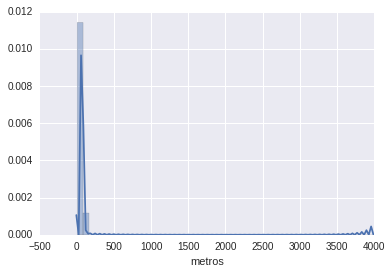

In [7]:
sns.distplot(rawdata['metros'])
plt.show()

In [8]:
rawdata[rawdata['metros']>200]

,Direccion,Planta,metros,habitaciones,Garaje,Precio,eur_metro,eur_metro_round
3781,"CALLE AMPARO, 12",4,335.0,2,0,685.0,2.044776,2.0
4815,"CALLE CARABIAS, 20",2,3979.0,2,0,480.0,0.120633,0.1


In [9]:
#Hay 2 valores que parecen errores de datos, los eliminamos

In [10]:
rawdata.drop(rawdata[rawdata['metros']>200].index, inplace=True)

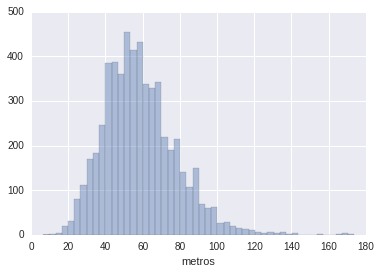

In [11]:
sns.distplot(rawdata['metros'], kde=False)
plt.show()

In [12]:
rawdata.describe()

,metros,Garaje,Precio,eur_metro,eur_metro_round
count,5654.000000,5654.000000,5654.000000,5654.000000,5654.000000
mean,58.748862,0.190308,691.816456,12.567935,12.567616
std,19.674518,0.392579,188.690085,3.903203,3.903617
min,6.470000,0.000000,300.000000,5.633803,5.600000
25%,45.000000,0.000000,570.000000,9.995226,10.000000
50%,56.425000,0.000000,650.000000,11.794593,11.800000
75%,70.000000,0.000000,750.000000,14.285714,14.300000
max,173.870000,1.000000,2500.000000,85.007728,85.000000


In [13]:
## Estudiamos los valores de euros

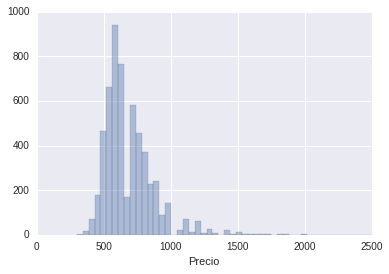

In [14]:
sns.distplot(rawdata['Precio'], kde=False)
plt.show()

In [15]:
rawdata[rawdata['Precio']>1800]

,Direccion,Planta,metros,habitaciones,Garaje,Precio,eur_metro,eur_metro_round
1099,"CALLE DOCTOR FLEMING, 11",2,165.60225,5,0,2500.0,15.096413,15.1
1177,"CALLE POTOSI, 4",4,110.91000,3,1,1850.0,16.680191,16.7
3915,"CALLE JESUS, 2",2,157.00000,3,0,2000.0,12.738854,12.7
4101,"CUESTA DE SANTO DOMINGO, 22",3,173.00000,4,0,2000.0,11.560694,11.6
4681,"CALLE LAGASCA, 95",3,103.00000,3,0,1850.0,17.961165,18.0


In [16]:
## Los valores de precio no parecen presentar problemas

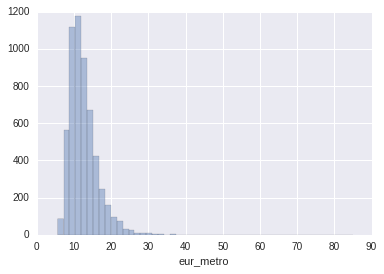

In [17]:
sns.distplot(rawdata['eur_metro'], kde=False)
plt.show()

In [18]:
# Traducir los valores de planta a los que existen en catastro para que el modelo se pueda
# aplicar a los datos reales

planta_ivima = pd.DataFrame((rawdata['Planta'].value_counts()).reset_index())
planta_ivima.rename(columns={'index':'planta', 'Planta':'elementos'}, inplace=True)

## Para cada planta de IVIMA hay que asociar el equivalente en catastro

## Añadimos una columna para buscar en catastro quitando los caracteres que no sean
# números ni letras 'º', asi tendremos los números

caracter_raro = planta_ivima[planta_ivima['planta'].str.contains('\W+')]['planta'].str.extract('(\W+)').unique()
planta_ivima['planta_busqueda'] = planta_ivima['planta']

for raro in caracter_raro:
    planta_ivima['planta_busqueda'] = planta_ivima['planta_busqueda'].str.replace(raro, '')

## La codificación de planta en catastro es de 2 caracteres

planta_ivima['planta_busqueda'] = planta_ivima['planta_busqueda'].apply(lambda x: '0' + x if len(x)==1 else x)
clean_dir = '../../../data/clean/ficheros_preparados/'

#Solo tenemos datos de alquiler de Madrid, utilizamos solo el catastro de Madrid

cat_data =  pd.read_csv(os.path.join(clean_dir, 'BI_28_900_U_2016-01-23.csv.gz'), low_memory=False, dtype='str')

# Solo estamos interesados en los bienes inmuebles del tipo vivienda

planta_cat = pd.DataFrame(cat_data[cat_data['clave_grupo_BI']=='V']['planta'].value_counts().reset_index())
planta_cat.rename(columns={'index':'planta_cat', 'planta':'elementos'}, inplace=True)

# Poblamos en plantas ivima los cruces directos

planta_ivima = pd.merge(planta_ivima, planta_cat, how='left', left_on='planta_busqueda', right_on='planta_cat', suffixes=('ivi', 'cat'))

## Exportamos la tabla para revisión manual de las asociaciones que no cruzan directamente

planta_ivima.to_csv(os.path.join(aux_dir, 'plantas_ivima.csv'))

## Revisar el fichero anterior externamente (Excel, editor texto, etc), para intentar asociar el literal
## de castastro de planta a los codigos de planta de IVIMA que no hemos podido poblar
## grabamos este fichero en out_dir/plantas_ivima.csv


planta_ivima_revisada = pd.read_csv(os.path.join(out_dir, 'plantas_ivima.csv'), sep=';', index_col=0)
planta_ivima_revisada = planta_ivima_revisada.drop(['planta', 'elementosivi', 'planta_busqueda', 'elementoscat'], axis=1)
planta_ivima = pd.merge(planta_ivima, planta_ivima_revisada, left_index=True, right_index=True)
planta_ivima = planta_ivima.drop(['planta_busqueda', 'planta_cat_x', 'elementoscat', 'elementosivi'], axis=1)
planta_ivima.rename(columns={'planta':'Planta', 'planta_cat_y':'planta_cat'}, inplace=True)

# poblamos los literales de planta de catastro en la tabla de datos

rawdata = pd.merge(rawdata, planta_ivima, how='left', left_on='Planta', right_on='Planta')

# separamos la direccion en calle y número. Lo necesitaremos en R para buscar el año de la finca en el catastro

direcciones = rawdata['Direccion'].str.split(',', expand = True)
direcciones.drop(2, axis=1, inplace = True)
direcciones.rename(columns={0:'Calle', 1:'numero'}, inplace=True)
rawdata = pd.concat([rawdata, direcciones], axis = 1)
rawdata['numero']=rawdata['numero'].str.strip()
rawdata['Calle']=rawdata['Calle'].str.strip()

# Sustituimos los nulos de número por ''

rawdata.loc[rawdata['numero'].isnull(), 'numero'] = ''

# Eliminar espacios del campo numero

rawdata['numero'] = rawdata['numero'].str.replace(' ', '')

# Analizamos el tipo de separador que hay en el campo 'numero'. (hay '-' y '/')

separadores = rawdata[rawdata['numero'].str.contains('\W+')]['numero'].str.extract('(\W+)').unique()

for separador in separadores:
    rawdata['numero'] = rawdata['numero'].str.replace(separador, '-')
    

# Separamos en el número si hay parte de Bis/Duplicado

numeros_tratar = rawdata[rawdata['numero'].str.isdigit() == False]

# Tratamos de forma diferente si hay un - o no

numeros_guion = numeros_tratar[numeros_tratar['numero'].str.find('-') != -1]

## Separamos por el guion y en el segundo campo sustituimos BIS por B

num_bis_guion = numeros_guion['numero'].str.split('-', expand = True)
num_bis_guion.rename(columns = {0:'num_pol', 1:'letra'}, inplace=True)

# las letras no pueden ser números, vaciamos las que lo sean

num_bis_guion['letra'] = num_bis_guion['letra'].apply(lambda x: '' if x.isdigit() else x)
num_bis_guion['letra'] = num_bis_guion['letra'].replace('BIS', 'B')

# Tratamos los que no tienen -

numeros_no_guion = numeros_tratar[numeros_tratar['numero'].str.find('-') == -1]
numeros_no_guion = numeros_no_guion.drop(numeros_no_guion.columns[:-1], axis=1)
numeros_no_guion['numero'] = numeros_no_guion['numero'].str.replace('BIS', 'B')
numeros_no_guion['num_pol'] = numeros_no_guion['numero'].str.extract('(\d+)', expand = True)
numeros_no_guion['letra'] = numeros_no_guion['numero'].str.extract('(\D+)', expand = True)
numeros_no_guion.drop('numero', axis=1, inplace=True)

## Unimos los resultados y añadimos a la tabla global

rawdata = pd.concat([rawdata, pd.concat([num_bis_guion, numeros_no_guion])], axis=1)
rawdata.loc[rawdata['num_pol'].isnull(), 'num_pol'] = rawdata['numero']
rawdata.loc[rawdata['letra'].isnull(), 'letra'] = ''

## En las letras con más de un caracter dejamos sólo el primero
rawdata.loc[rawdata['letra'] <> '', 'letra'] = rawdata['letra'].str[0]

## Los números de policia de catastro tienen 4 caracteres

rawdata['num_pol'] = rawdata['num_pol'].str.rjust(width = 4, fillchar='0')
rawdata.to_csv(os.path.join(out_dir, 'fincas_ivima.csv'), index = False, sep='^')

/home/manu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
/home/manu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:74: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
